In [55]:
# dataset = https://www.kaggle.com/datasets/jangedoo/utkface-new

In [56]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [57]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [58]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [59]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Load & preprocess data

image_directory = '/content/UTKFace/'
img_size = (128, 128)
batch_size = 16

import re

def load_images(image_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Check if the filename follows the expected format
            label = filename.split('_')
            if len(label) == 4:  # Expecting 4 parts: age, gender, ethnicity, and image file extension
                try:
                    age = int(label[0])
                    gender = int(label[1])  # 0: Male, 1: Female
                    ethnicity = int(label[2])  # 0: White, 1: Black, 2: Asian, etc.

                    # Load and preprocess image
                    img = image.load_img(os.path.join(image_dir, filename), target_size=image_size)
                    img_array = image.img_to_array(img)
                    img_array = preprocess_input(img_array)
                    images.append(img_array)

                    labels.append([age, gender, ethnicity])
                except ValueError:
                    # If there's an issue parsing age, gender, or ethnicity, skip the file
                    print(f"Skipping file: {filename} due to incorrect format")
            else:
                print(f"Skipping file: {filename} due to incorrect structure")

    return np.array(images), np.array(labels)

In [60]:
images, labels = load_images(image_directory)

Skipping file: 39_1_20170116174525125.jpg.chip.jpg due to incorrect structure
Skipping file: 61_1_20170109142408075.jpg.chip.jpg due to incorrect structure
Skipping file: 61_1_20170109150557335.jpg.chip.jpg due to incorrect structure


In [61]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of data for validation
)

# Load training data from the root directory (no class directories)
train_generator = train_datagen.flow_from_directory(
    image_directory,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=True,
    classes=['.']  # Load from root directory (without subdirectories)
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    image_directory,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False,
    classes=['.']
)

Found 18967 images belonging to 1 classes.
Found 4741 images belonging to 1 classes.


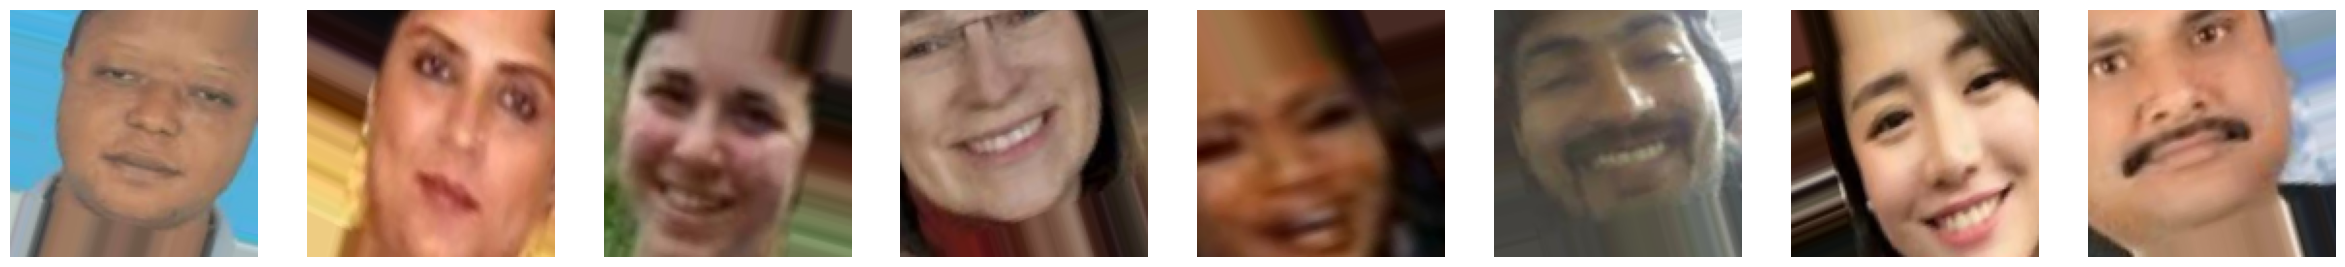

In [62]:
import matplotlib.pyplot as plt

def plot_image_grid(generator, batch_size=8):
    # Get a batch of images
    batch_images = next(generator)

    # Create a grid of images
    fig, axes = plt.subplots(1, batch_size, figsize=(30, 30))
    for i in range(batch_size):
        ax = axes[i]
        ax.imshow(batch_images[i])
        ax.axis('off')
    plt.show()

# Example usage with train_generator
plot_image_grid(train_generator, batch_size=8)


In [63]:
# Pretrained Model ResNet50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add custom layers for our task
x = base_model.output
x = Flatten()(x)
age_output = Dense(1, activation='linear', name='age')(x)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)
ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=[age_output, gender_output, ethnicity_output])

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss={'age': 'mse', 'gender': 'binary_crossentropy', 'ethnicity': 'categorical_crossentropy'},
              metrics={'age': 'mae', 'gender': 'accuracy', 'ethnicity': 'accuracy'})

In [64]:
# Train the model

from sklearn.model_selection import train_test_split

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Separate labels for different outputs
y_train_age = y_train[:, 0]
y_train_gender = y_train[:, 1]
y_train_ethnicity = tf.keras.utils.to_categorical(y_train[:, 2], num_classes=5)

# Train the model
history = model.fit(X_train, {'age': y_train_age, 'gender': y_train_gender, 'ethnicity': y_train_ethnicity},
                    validation_split=0.1, epochs=10, batch_size=16)

Epoch 1/10
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 349s 318ms/step - age_mae: 11.4194 - ethnicity_accuracy: 0.5284 - gender_accuracy: 0.7768 - loss: 240.6197 - val_age_mae: 9.3659 - val_ethnicity_accuracy: 0.6257 - val_gender_accuracy: 0.7849 - val_loss: 157.6747
Epoch 2/10
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 376s 312ms/step - age_mae: 9.0331 - ethnicity_accuracy: 0.6732 - gender_accuracy: 0.8399 - loss: 141.6538 - val_age_mae: 9.4085 - val_ethnicity_accuracy: 0.6310 - val_gender_accuracy: 0.8134 - val_loss: 161.1595
Epoch 3/10
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 434s 361ms/step - age_mae: 8.4044 - ethnicity_accuracy: 0.7111 - gender_accuracy: 0.8624 - loss: 124.0352 - val_age_mae: 9.1984 - val_ethnicity_accuracy: 0.6352 - val_gender_accuracy: 0.7649 - val_loss: 154.4073
Epoch 4/10
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 392s 315ms/step - age_mae: 8.2464 - ethnicity_accuracy: 0.7371 - gender_accuracy: 0.8692 - loss: 117.3104 - val_age_mae: 9.2238 - val_ethnicity_accuracy: 0.6468 - val_gender_accuracy: 0.8192 - va

In [71]:
# Evaluate & predict

# Test the model
y_test_age = y_test[:, 0]
y_test_gender = y_test[:, 1]
y_test_ethnicity = tf.keras.utils.to_categorical(y_test[:, 2], num_classes=5)

test_results = model.evaluate(X_test, {'age': y_test_age, 'gender': y_test_gender, 'ethnicity': y_test_ethnicity})

# Make predictions
predictions = model.predict(X_test)
predicted_age = predictions[0]
predicted_gender = predictions[1]
predicted_ethnicity = predictions[2]

149/149 ━━━━━━━━━━━━━━━━━━━━ 76s 508ms/step - age_mae: 9.4811 - ethnicity_accuracy: 0.6623 - gender_accuracy: 0.8162 - loss: 165.3343
149/149 ━━━━━━━━━━━━━━━━━━━━ 77s 514ms/step


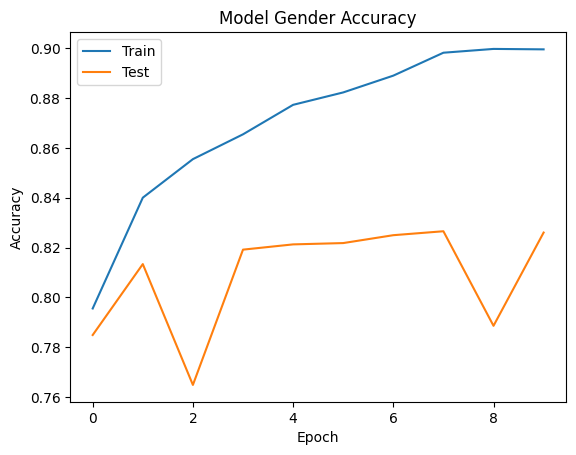

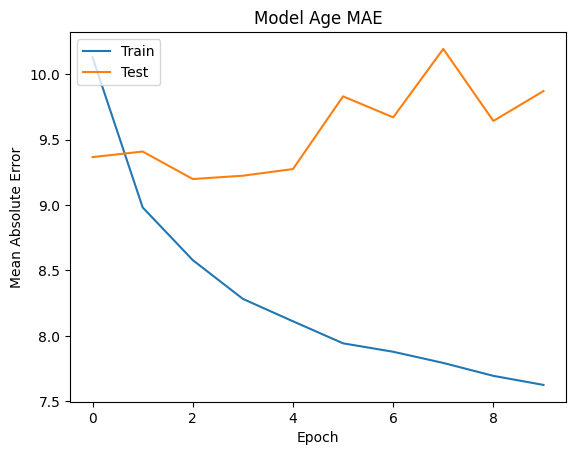

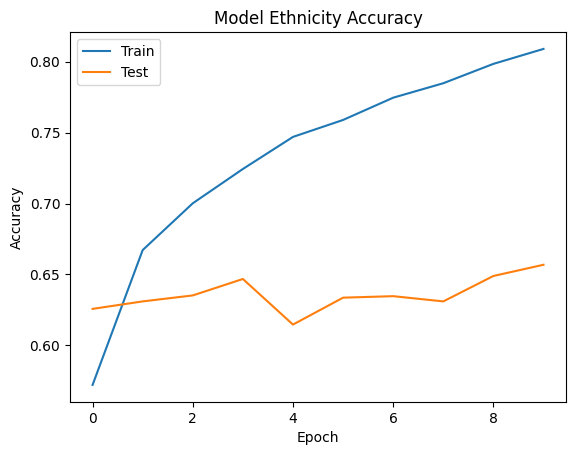

In [72]:
# Visualise results

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('Model Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation MAE values for age
plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('Model Age MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values for ethnicity
plt.plot(history.history['ethnicity_accuracy'])
plt.plot(history.history['val_ethnicity_accuracy'])
plt.title('Model Ethnicity Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [73]:
import os

# Create an index that stores the image filenames and corresponding labels (age, gender, ethnicity)
def create_image_index(image_dir):
    image_index = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            label = filename.split('_')
            if len(label) == 4:  # Ensure correct filename structure
                try:
                    age = int(label[0])
                    gender = int(label[1])
                    ethnicity = int(label[2])
                    image_index.append({
                        'filename': filename,
                        'age': age,
                        'gender': gender,
                        'ethnicity': ethnicity
                    })
                except ValueError:
                    continue
    return image_index

# Example usage to create the index
image_directory = '/content/UTKFace'  # Change to your dataset path
image_index = create_image_index(image_directory)

Processing image: /content/UTKFace/22_1_0_20170116220934918.jpg.chip.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Raw Predictions: [array([[19.90524]], dtype=float32), array([[0.99889755]], dtype=float32), array([[1.0000000e+00, 3.5526503e-20, 2.7824440e-17, 6.2430127e-15,
        4.9906273e-14]], dtype=float32)]


<ipython-input-74-be6873248a3e>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_age = float(pred_age)


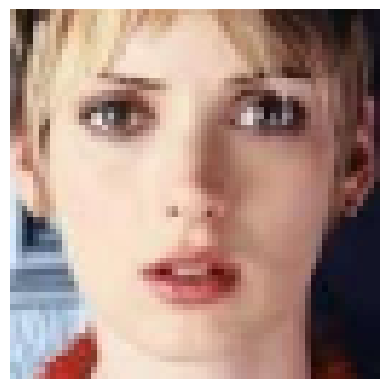

Original Age: 22, Predicted Age: 19.9
Original Gender: Female, Predicted Gender: Female
Original Ethnicity: White, Predicted Ethnicity: White


In [74]:
def show_prediction_from_index(index_entry, image_dir):
    image_path = os.path.join(image_dir, index_entry['filename'])
    true_age = index_entry['age']
    true_gender = index_entry['gender']
    true_ethnicity = index_entry['ethnicity']

    # Load and preprocess the image
    img = load_single_image(image_path)

    print(f"Processing image: {image_path}")

    # Predict using the trained model
    preds = model.predict(img)

    # Debugging: Check the output of the predictions
    print(f"Raw Predictions: {preds}")

    # Decode the predictions
    pred_age, pred_gender, pred_ethnicity = decode_predictions(preds)

    # Convert NumPy array to float for formatting
    pred_age = float(pred_age)

    # Map gender and ethnicity for display
    true_gender_label = "Male" if true_gender == 0 else "Female"
    pred_gender_label = "Male" if pred_gender == 0 else "Female"
    true_ethnicity_label = ethnicity_labels[true_ethnicity]
    pred_ethnicity_label = ethnicity_labels[pred_ethnicity]

    # Display the image
    img_display = image.load_img(image_path, target_size=image_size)

    # Debugging: Ensure the image is loaded correctly
    plt.imshow(img_display)
    plt.axis('off')
    plt.show()

    # Print the results
    print(f"Original Age: {true_age}, Predicted Age: {pred_age:.1f}")
    print(f"Original Gender: {true_gender_label}, Predicted Gender: {pred_gender_label}")
    print(f"Original Ethnicity: {true_ethnicity_label}, Predicted Ethnicity: {pred_ethnicity_label}")

# Example usage: Display prediction for the first image in the index
show_prediction_from_index(image_index[1], image_directory)

Processing image: /content/UTKFace/65_1_0_20170110143547028.jpg.chip.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Raw Predictions: [array([[62.63593]], dtype=float32), array([[0.9999995]], dtype=float32), array([[1.0000000e+00, 1.5951013e-09, 1.8216149e-12, 8.5313963e-15,
        4.1517193e-12]], dtype=float32)]


<ipython-input-74-be6873248a3e>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_age = float(pred_age)


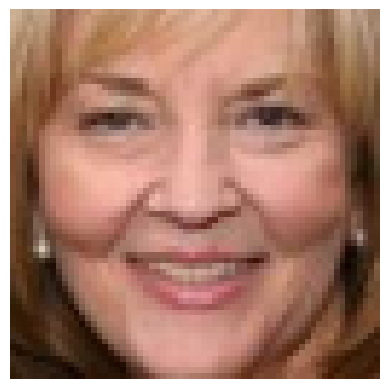

Original Age: 65, Predicted Age: 62.6
Original Gender: Female, Predicted Gender: Female
Original Ethnicity: White, Predicted Ethnicity: White


In [77]:
show_prediction_from_index(image_index[100], image_directory)

Processing image: /content/UTKFace/36_0_1_20170113142202668.jpg.chip.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Raw Predictions: [array([[39.175564]], dtype=float32), array([[6.312557e-06]], dtype=float32), array([[4.9791828e-09, 1.0000000e+00, 4.6708930e-17, 3.4179242e-17,
        5.1813652e-31]], dtype=float32)]


<ipython-input-74-be6873248a3e>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_age = float(pred_age)


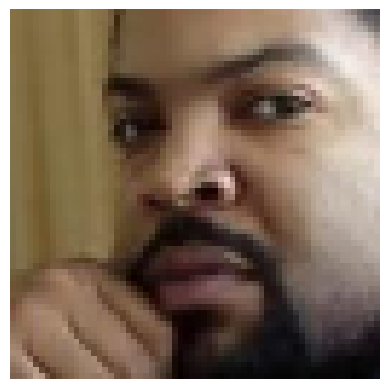

Original Age: 36, Predicted Age: 39.2
Original Gender: Male, Predicted Gender: Male
Original Ethnicity: Black, Predicted Ethnicity: Black


In [76]:
show_prediction_from_index(image_index[1000], image_directory)

Processing image: /content/UTKFace/26_0_0_20170119180222692.jpg.chip.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Raw Predictions: [array([[23.049004]], dtype=float32), array([[0.01335012]], dtype=float32), array([[9.6953368e-01, 3.6712461e-06, 2.9809788e-02, 8.5252333e-07,
        6.5195496e-04]], dtype=float32)]


<ipython-input-74-be6873248a3e>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_age = float(pred_age)


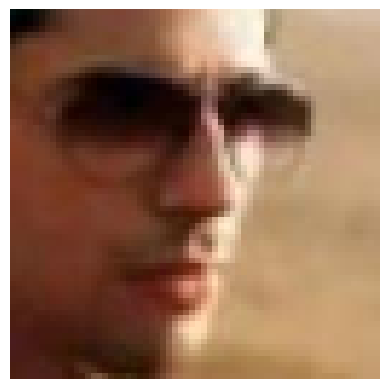

Original Age: 26, Predicted Age: 23.0
Original Gender: Male, Predicted Gender: Male
Original Ethnicity: White, Predicted Ethnicity: White


In [79]:
show_prediction_from_index(image_index[5000], image_directory)

Processing image: /content/UTKFace/20_1_3_20170104222034231.jpg.chip.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Raw Predictions: [array([[27.132986]], dtype=float32), array([[0.9999999]], dtype=float32), array([[2.2444163e-02, 4.4462740e-04, 2.8692752e-06, 9.7451687e-01,
        2.5914267e-03]], dtype=float32)]


<ipython-input-74-be6873248a3e>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_age = float(pred_age)


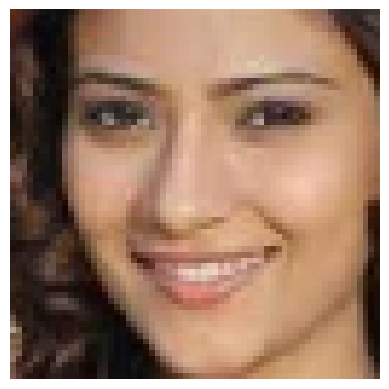

Original Age: 20, Predicted Age: 27.1
Original Gender: Female, Predicted Gender: Female
Original Ethnicity: Indian, Predicted Ethnicity: Indian


In [84]:
show_prediction_from_index(image_index[20000], image_directory)

Processing image: /content/UTKFace/30_1_1_20170112193112574.jpg.chip.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Raw Predictions: [array([[30.889618]], dtype=float32), array([[0.893119]], dtype=float32), array([[7.1855538e-05, 9.9990714e-01, 1.6465387e-05, 4.4781232e-06,
        8.5957741e-11]], dtype=float32)]


<ipython-input-74-be6873248a3e>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_age = float(pred_age)


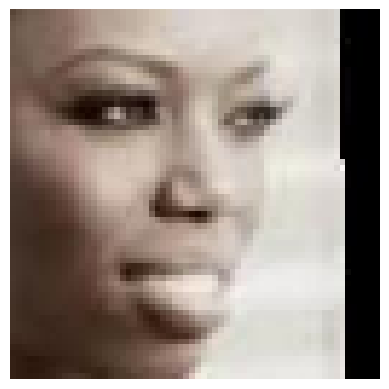

Original Age: 30, Predicted Age: 30.9
Original Gender: Female, Predicted Gender: Female
Original Ethnicity: Black, Predicted Ethnicity: Black


In [86]:
show_prediction_from_index(image_index[23000], image_directory)